In [125]:
import os
import sys
sys.path.append("..")  # add top folder to path
from collections import Counter

import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
import torch

import impepdom

In [20]:
def weighted_harmonic_mean(var_1, var_2, beta=1):  # should make it generalizable to many variables
    '''
    Harmonic mean for two parameters with weighting.
    
    Parameters
    ----------
    var_1, var_2: int or ndarray
        Variables to consider
        
    beta: float, optional
        Importance of `var_2` relative to `var_1`.
        If beta == 1, this function is equivalent to `scipy.stats.hmean()`
    '''
    
    return (1 + beta**2) * np.multiply(var_1, var_2) / (beta**2 * var_1 + var_2)

In [21]:
### import csv and extract the best hyperparameters

path = '../store/hyperparams'

hyperparams = []
all_files = os.listdir(path)
all_files.remove('.DS_Store')
all_files.remove('.gitkeep')

for file in all_files:
    all_name = file[10:-6] + ':' + file[-6:-4]
    allele = 'HLA-' + all_name.upper() # change to appropriate name
    df = pd.read_csv(path + '/' + file)
    idx = (df['min_auc'].notna() & df['mean_ppv'].notna())
    
    metric_1, metric_2 = np.array(df['min_auc'][idx]), np.array(df['mean_ppv'][idx])
    beta = 1  # how much the second metric should be weighted compared to the first
    w_hmean = weighted_harmonic_mean(metric_1, metric_2, beta=0.6)
    
    best_3_rows = (-w_hmean).argsort()[:3] # for top 3 rows with best harmonic mean value
    # best_3_rows = (-sts.hmean([df['min_auc'][idx], df['mean_ppv'][idx]])).argsort()[:3]
    
    batch_sizes = list(df['batch_size'][best_3_rows].astype('int'))
    batch_counter = Counter(batch_sizes)
    batch_sz = batch_counter.most_common(1)[0][0]
    
    hyperparams.append({
        'hla_allele': allele, 
        'padding': 'flurry',
        'batch_size': batch_sz, 
        'num_epochs': int(np.mean(df['num_epochs'][best_3_rows])),
        'learning_rate': float(np.mean(df['learning_rate'][best_3_rows])),
        'min_auc': list(metric_1[best_3_rows]),
        'mean_ppv': list(metric_2[best_3_rows])
    })

In [22]:
hyperparams

[{'hla_allele': 'HLA-B08:01',
  'padding': 'flurry',
  'batch_size': 32,
  'num_epochs': 12,
  'learning_rate': 0.005,
  'min_auc': [0.9427044270366984, 0.9489961025246252, 0.9406019689217802],
  'mean_ppv': [0.8009561955349958, 0.7874216018798996, 0.8008898669990216]},
 {'hla_allele': 'HLA-A68:01',
  'padding': 'flurry',
  'batch_size': 32,
  'num_epochs': 8,
  'learning_rate': 0.008333333333333333,
  'min_auc': [0.9675087544757478, 0.9643162617643136, 0.972510289685355],
  'mean_ppv': [0.8320459201732822, 0.8316849619364933, 0.8126888588465029]},
 {'hla_allele': 'HLA-B15:01',
  'padding': 'flurry',
  'batch_size': 32,
  'num_epochs': 11,
  'learning_rate': 0.01,
  'min_auc': [0.95786068457996, 0.9593241833100687, 0.9507864963846296],
  'mean_ppv': [0.8361606495971877, 0.8309160884485705, 0.8477306769998741]},
 {'hla_allele': 'HLA-B44:03',
  'padding': 'flurry',
  'batch_size': 32,
  'num_epochs': 7,
  'learning_rate': 0.01,
  'min_auc': [0.969096172812565, 0.9621737654739932, 0.96305

In [23]:
### train models with these hyperparameters

results = []

impepdom.time_tracker.reset_timer() 

for hyp in hyperparams:
    print('working with allele', hyp['hla_allele'])
    model = impepdom.models.MultilayerPerceptron(num_hidden_layers=2, hidden_layer_size=100)

    dataset = impepdom.PeptideDataset(
        hla_allele=hyp['hla_allele'],
        padding='flurry',
        toy=False)

    save_folder, baseline_metrics, _ = impepdom.run_experiment(
        model=model,
        dataset=dataset,
        train_fold_idx=[0, 1, 2, 3],
        learning_rate=hyp['learning_rate'],
        num_epochs=hyp['num_epochs'],
        batch_size=hyp['batch_size'])
    
    trained_model, train_history = impepdom.load_trained_model(model, save_folder)
    
    
    X_test, y_test = dataset.get_fold(fold_idx=[4])
    y_proba = model(torch.tensor(X_test, dtype=torch.float)).detach().numpy()
    
    results.append({
        'hla_allele': hyp['hla_allele'],
        'y_test': y_test,
        'y_proba': y_proba
        })

working with allele HLA-B08:01
[0 m 16 s] peptide dataset initialized
epoch 1/12 started at 0.0005 s
train loss: 0.0674 accuracy: 0.9830 auc: 0.9213

epoch 2/12 started at 17.1266 s
train loss: 0.0627 accuracy: 0.9843 auc: 0.9351

epoch 3/12 started at 34.1811 s
train loss: 0.0630 accuracy: 0.9843 auc: 0.9351

epoch 4/12 started at 51.1212 s
train loss: 0.0617 accuracy: 0.9849 auc: 0.9391

epoch 5/12 started at 68.8133 s
train loss: 0.0642 accuracy: 0.9844 auc: 0.9376

epoch 6/12 started at 89.2755 s
train loss: 0.0642 accuracy: 0.9842 auc: 0.9373

epoch 7/12 started at 109.5753 s
train loss: 0.0664 accuracy: 0.9839 auc: 0.9359

epoch 8/12 started at 128.2455 s
train loss: 0.0636 accuracy: 0.9842 auc: 0.9421

epoch 9/12 started at 146.6778 s
train loss: 0.0668 accuracy: 0.9844 auc: 0.9430

epoch 10/12 started at 164.1794 s
train loss: 0.0697 accuracy: 0.9839 auc: 0.9412

epoch 11/12 started at 181.3512 s
train loss: 0.0709 accuracy: 0.9843 auc: 0.9386

epoch 12/12 started at 198.5477 s

In [48]:
### report metrics

all_y_true = []
all_y_proba = []

allele_store = []
n_store = []
n_bind_store = []
pcc_store = []
auc_store = []
auc_01_store = []
ppv_store = []
ppv_100_store = []

for result in results:
    
    y_true = result['y_test']
    y_proba = result['y_proba'].flatten()
    
    all_y_true.append(y_true)
    all_y_proba.append(y_proba)
    
    allele_store.append(result['hla_allele'])
    n_store.append(len(y_true))
    n_bind_store.append(sum(y_true == 1))
    pcc_store.append(sts.pearsonr(y_true, y_proba)[0])
    auc_store.append(impepdom.metrics.auc(y_true, y_proba))
    auc_01_store.append(impepdom.metrics.auc_01(y_true, y_proba))
    ppv_store.append(impepdom.metrics.ppv(y_true, y_proba))
    ppv_100_store.append(impepdom.metrics.ppv_100(y_true, y_proba))
    
metrics_report = pd.DataFrame({
    'Allele': allele_store,
    'N': n_store,
    'Nbind': n_bind_store,
    'PCC': pcc_store,
    'AUC': auc_store,
    'AUC01': auc_01_store,
    'PPV': ppv_store,
    'PPV100': ppv_100_store
    })

all_y_true = np.hstack(all_y_true)
all_y_proba = np.hstack(all_y_proba)

In [83]:
y_proba[y_true == 1]

array([0.27672467, 0.11641078, 0.11641078, ..., 0.11641078, 0.06614305,
       0.08712794], dtype=float32)

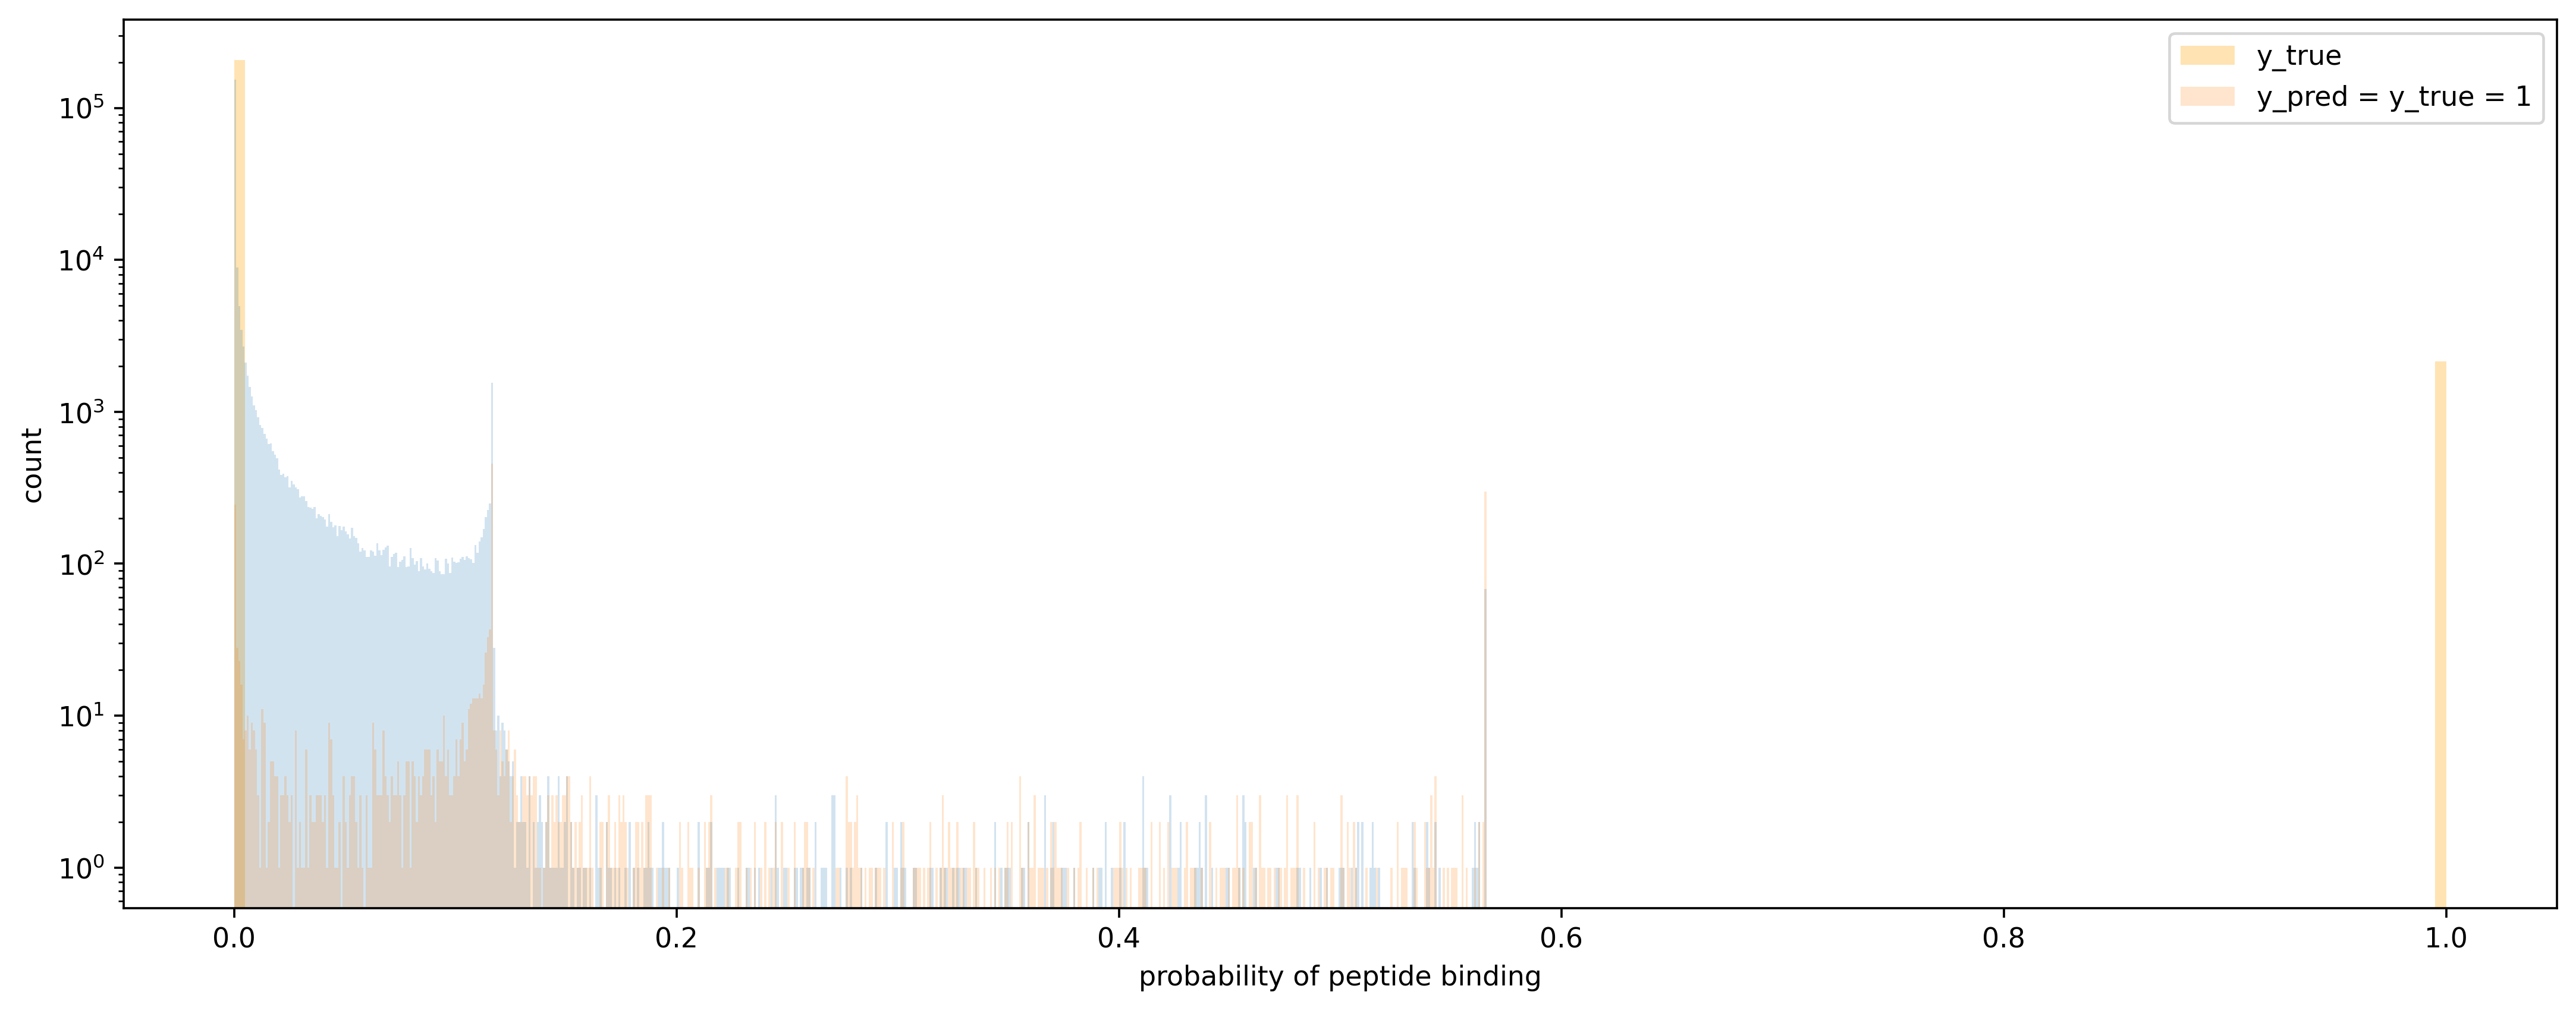

In [114]:
plt.figure(figsize=(16, 6), dpi=330)

plt.hist(y_true, bins=200, color='orange', alpha=0.3, label='y_true')
plt.hist(y_proba[y_true == 0], bins=600, alpha=0.2, label='')
plt.hist(y_proba[y_true == 1], bins=600, alpha=0.2, label='y_pred = y_true = 1')

plt.yscale('log')
plt.xlabel('probability of peptide binding')
plt.ylabel('count')
plt.legend()
plt.show()

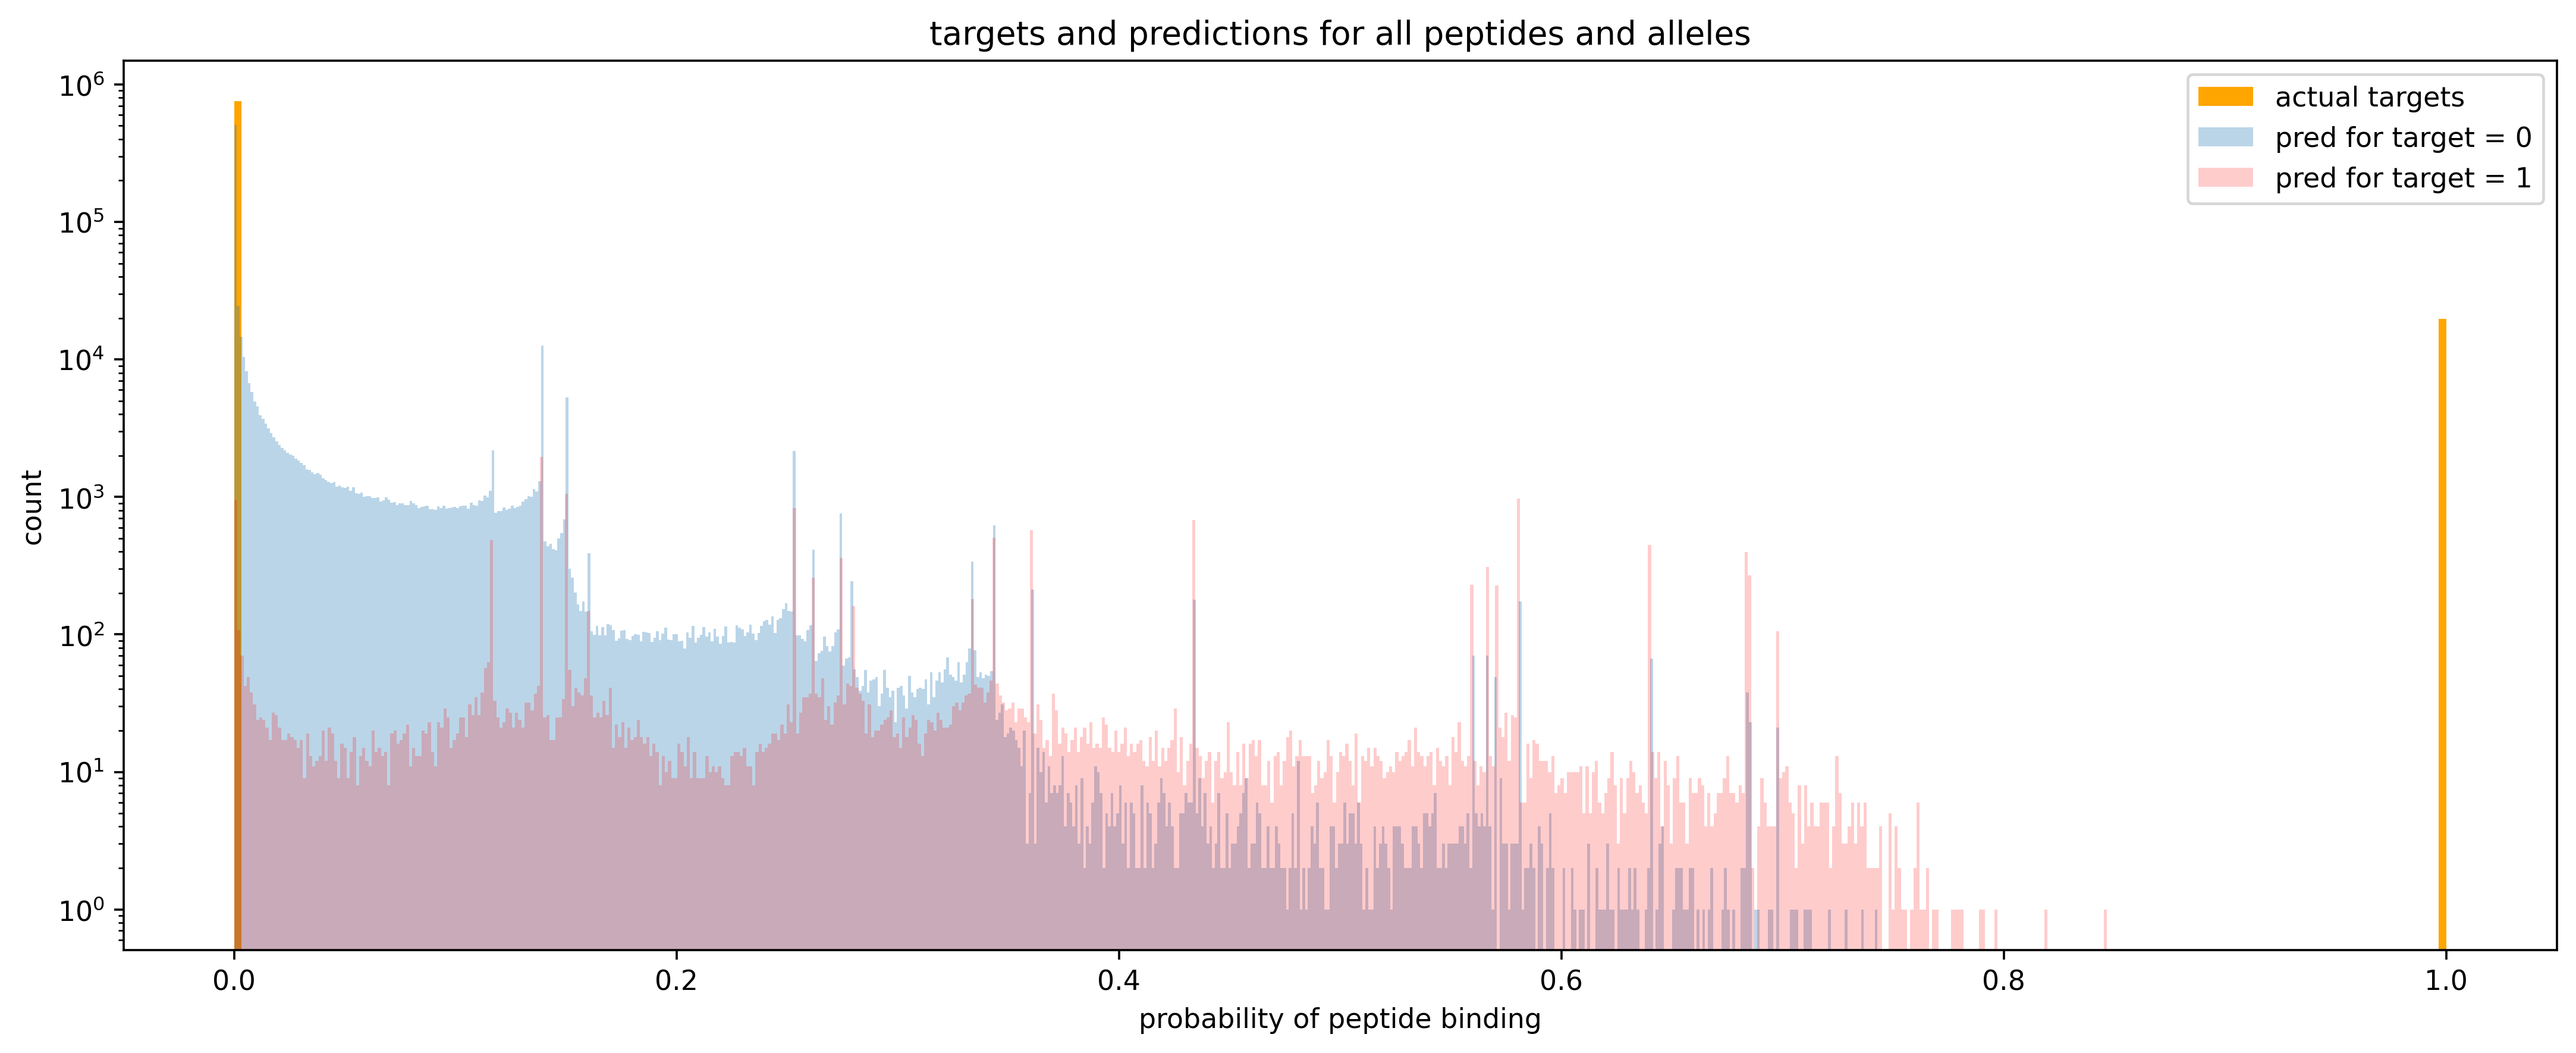

In [113]:
plt.figure(figsize=(16, 6), dpi=330)

plt.title('targets and predictions for all peptides and alleles')
plt.hist(all_y_true, bins=300, color='orange', alpha=1, label='actual targets')
plt.hist(all_y_proba[all_y_true == 0], bins=600, alpha=0.3, label='pred for target = 0')
plt.hist(all_y_proba[all_y_true == 1], bins=600, alpha=0.2, label='pred for target = 1', color='red')

plt.yscale('log')
plt.xlabel('probability of peptide binding')
plt.ylabel('count')
plt.legend()
plt.show()

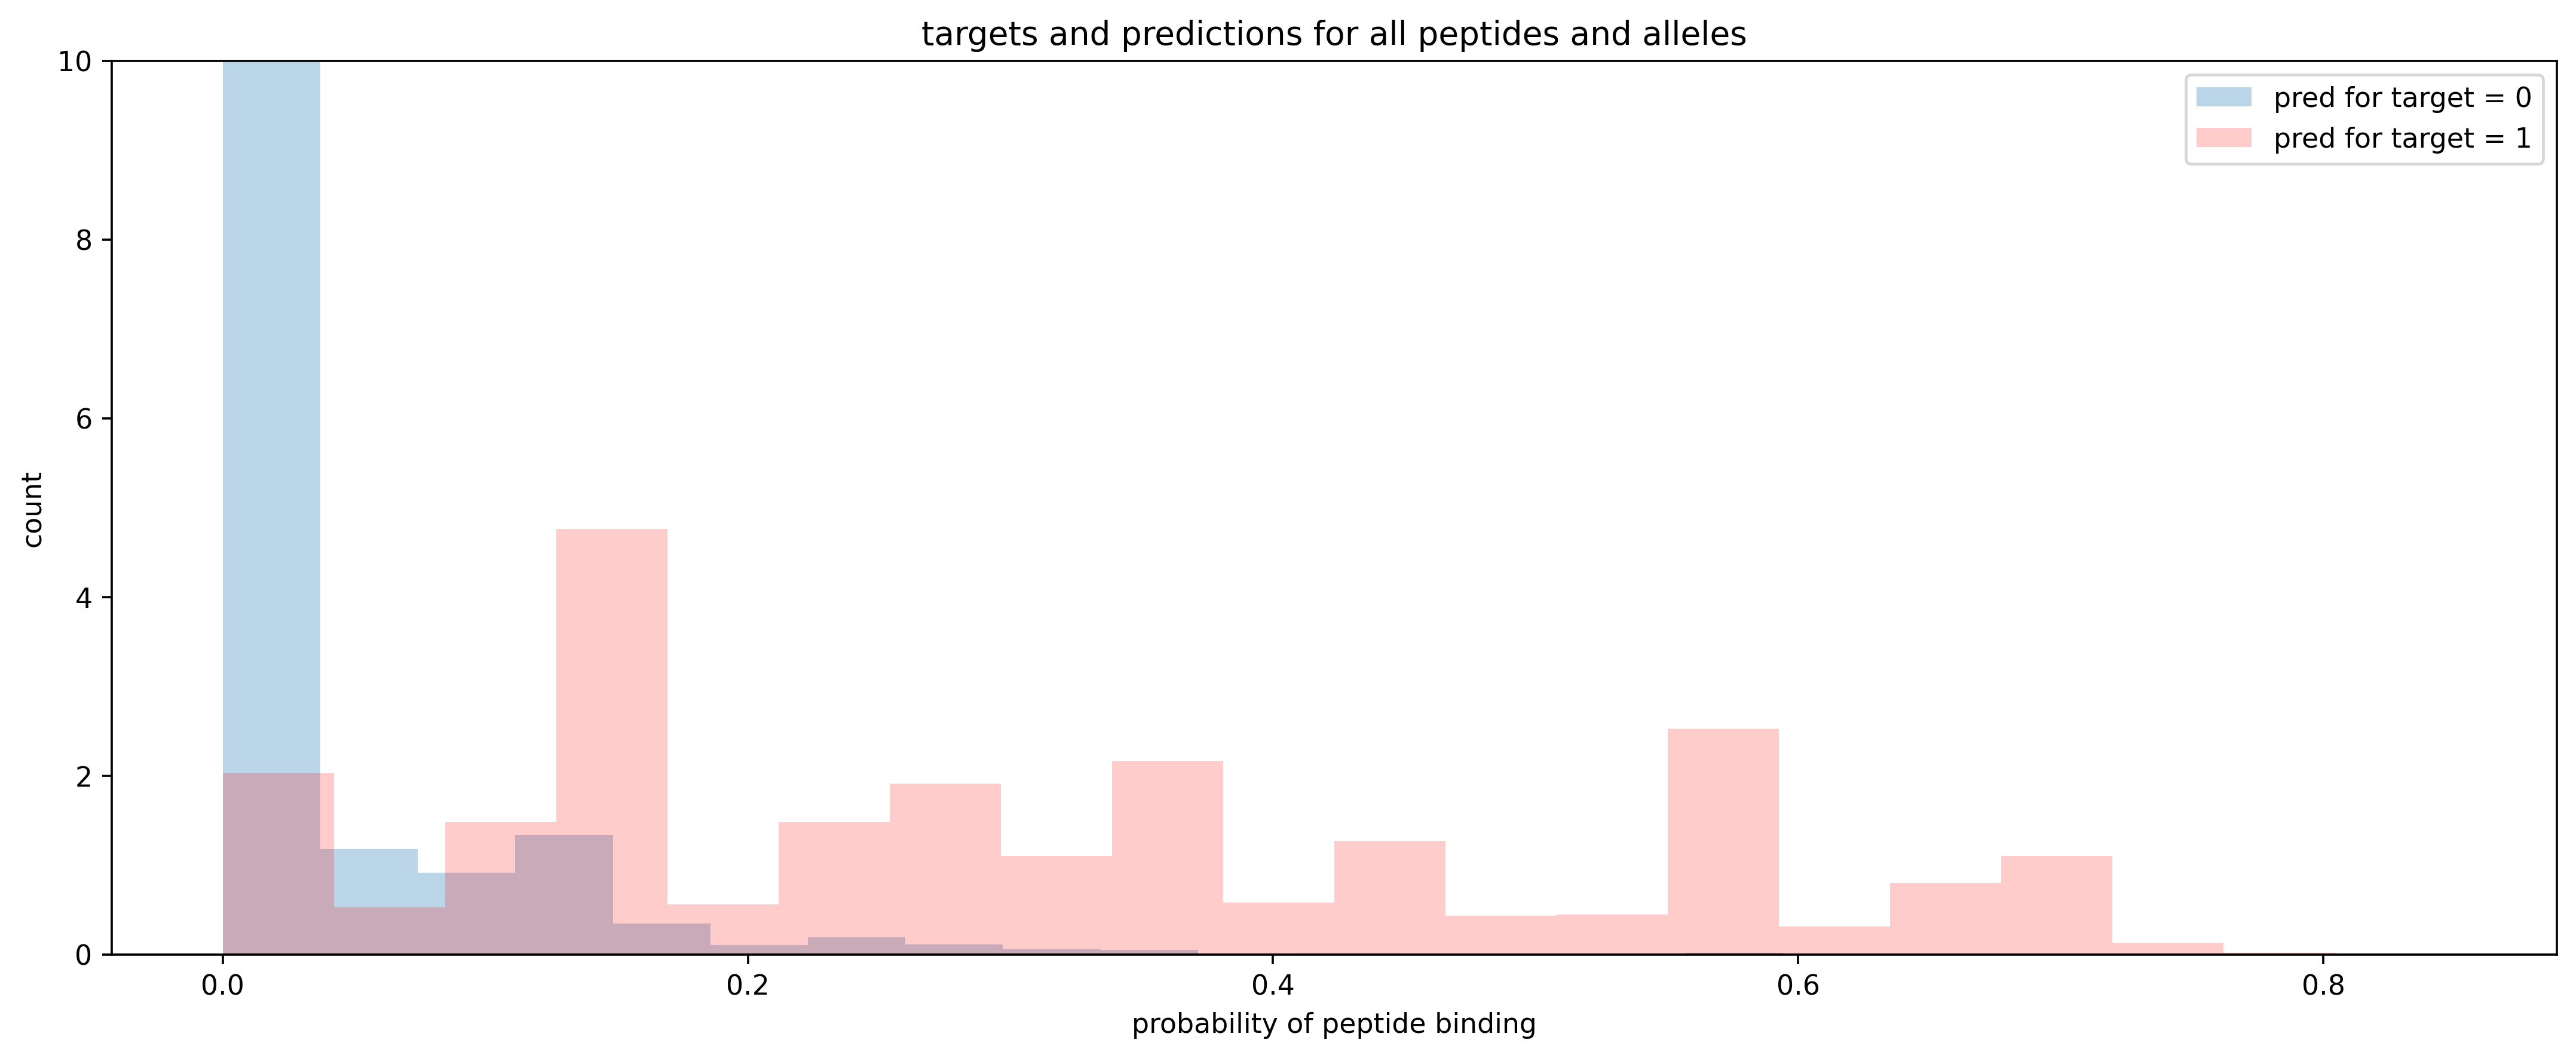

In [133]:
plt.figure(figsize=(16, 6), dpi=330)

plt.title('targets and predictions for all peptides and alleles')
# plt.hist(all_y_true, bins=300, color='orange', alpha=1, label='actual targets')
plt.hist(all_y_proba[all_y_true == 0], bins=20, alpha=0.3, label='pred for target = 0', density=True)
plt.hist(all_y_proba[all_y_true == 1], bins=20, alpha=0.2, label='pred for target = 1', color='red', density=True)

plt.xlabel('probability of peptide binding')
plt.ylim(0, 10)
plt.ylabel('count')
plt.legend()
plt.show()

In [124]:
# print('AUC for all:', sklearn.metrics.roc_auc_score(all_y_true, all_y_proba))
# print('PCC for all:', scipy.stats.pearsonr(all_y_true, all_y_proba)[0])

AUC for all: 0.9443449396656737
PCC for all: 0.5780084122302134


In [82]:
def sort_metrics_report(_metrics_report, allele_order=None):
    '''
    Sort report table based on the order of HLA alleles.
    '''
    
    if not allele_order:
        allele_order = ['HLA-A01:01', 'HLA-A03:01', 'HLA-A02:01', 'HLA-B07:02', 'HLA-B44:03', 'HLA-A68:01', 'HLA-A24:02', 'HLA-B27:05', 'HLA-B08:01', 'HLA-B15:01']
        
    metrics_report = _metrics_report.copy()
    sorter_index = dict(zip(allele_order, range(len(allele_order))))
    metrics_report['_'] = metrics_report['Allele'].map(sorter_index)
    
    metrics_report.sort_values(by=['_'], inplace=True)
    metrics_report.drop(['_'], axis=1, inplace=True)
    metrics_report.reset_index(drop=True, inplace=True)
    
    return metrics_report

In [53]:
metrics_report = sort_metrics_report(metrics_report)
metrics_report

,Allele,N,Nbind,PCC,AUC,AUC01,PPV,PPV100
0,HLA-A01:01,209698,2150,0.492439,0.918664,0.854229,0.556279,1.00
1,HLA-A03:01,100012,2921,0.462530,0.929708,0.831873,0.509415,1.00
2,HLA-A02:01,187844,3372,0.329599,0.908478,0.774917,0.763642,1.00
3,HLA-B07:02,59311,2576,0.652514,0.969410,0.900796,0.852873,1.00
4,HLA-B44:03,24073,1488,0.734715,0.968352,0.921340,0.841398,0.99
5,HLA-A68:01,39201,2081,0.685623,0.971007,0.916441,0.817395,0.92
6,HLA-A24:02,55304,1297,0.570687,0.962827,0.887903,0.699306,1.00
7,HLA-B27:05,29995,1775,0.679969,0.965615,0.896859,0.728451,0.93
8,HLA-B08:01,49804,997,0.670763,0.950224,0.907636,0.730191,0.95
9,HLA-B15:01,23235,1159,0.730018,0.967792,0.918073,0.784297,1.00


In [27]:
os.makedirs('../store/reports', exist_ok=True)
metrics_report.to_csv('../store/reports/mlp_2x100_flurry_report_v5.1_hmean_min_auc_mean_ppv.csv')

In [71]:
x = [0.01, 0.011, 0.012, 0.3, 0.4, 0.9, 0.8]
y = [0, 0, 0, 1, 1, 1, 1]

In [72]:
sts.pearsonr(x, y)

(0.8341497442853234, 0.01963473760445837)

In [75]:
sts.pearsonr(all_y_true, all_y_proba)

(0.5780084122302134, 0.0)